In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [3]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl       = None
do_allcycl   = False
which_isopyc = 36.72
vname        = 'w_diap'
year         = [1979,2019]
mon          = None
day          = None
record       = None 
box          = None
depth        = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tpc'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True

In [2]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

 --> memory_limit: 2.778 GB


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)      
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


### ATTENTION:
use here the density MOC levels that are specfic for your run. They might be different from the one im using here since they might need to be customized specific to your hydrography to be able to cover the whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

In [5]:
#______________________________________________________________________________________________________        
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

In [6]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
# load divergence of density class
wdiap_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________    
    data = tpv.load_dmoc_data(mesh, datapath, descript, year, 'dmoc', std_dens, do_wdiap=True, do_info=False, 
                              do_bolus=do_bolus, add_bolus=True, do_load=False, do_persist=True)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')

    #___COMPUTE DIAPYCNAL VERTICAL VELOCITY________________________________________________________________
    # finds closest index of isopycnal class
    ts          = clock.time()
    ndens       = len(std_dens)
    idx_isopycn = np.argmin(np.abs(np.array(std_dens)-which_isopyc))
    print(' sigma_2 = {:5.2f} kg/m^3'.format(std_dens[idx_isopycn]))

    # integrate (xr.sum) divergence over all density classes below idx_isopycn     
    ts = clock.time()
    var   = list(data.keys())[0]
    wdiap = data.isel(ndens=range(ndens-1,idx_isopycn-1,-1)).sum(dim='ndens',skipna=True).rename({var:'w_diap'})
    # wdiap = data.isel(ndens=idx_isopycn).rename({var:'w_diap'})
    del(data)
    wdiap['w_diap'] = wdiap['w_diap'].assign_attrs({
                       'description':'diapycnal velocity',
                       'long_name'  :'diapycnal velocity',
                       'short_name' :'w_diapyc',
                       'units'      :'m/s',
                       'str_ldep'   :', $\\sigma_{{2}}$={:5.2f} kg$\\cdot$m$^{{-3}}$'.format(std_dens[idx_isopycn])})
    wdiap = wdiap.load()
    if (ref_path != None): 
        if ii == 0: 
            wdiap_ref = wdiap.copy()
            if do_reffig: wdiap_list.append(wdiap_ref) 
        else:        
            wdiap_list.append( tpv.do_anomaly(wdiap, wdiap_ref) )
    else:                                                   
        wdiap_list.append( wdiap )
    del(wdiap)    
    print(' --> elasped time to select data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> dflux uses {:3.2f} Gb:'.format(wdiap_list[-1].nbytes/(1024**3)))
    print('')

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.04 min.
 --> data uses 0.04 Gb:

 sigma_2 = 36.72 kg/m^3
 --> elasped time to select data: 0.04 min.
 --> dflux uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.03 min.
 --> data uses 0.04 Gb:

 sigma_2 = 36.72 kg/m^3
 --> elasped time to select data: 0.03 min.
 --> dflux uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.03 min.
 --> data uses 0.04 Gb:

 sigma_2 = 36.72 kg/m^3
 --> elasped time to select data: 0.03 min.
 --> dflux uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.03 min.
 --> data uses 0.04 Gb:

 sigma_2 = 36.72 kg/m^3
 --> e

In [7]:
# do regular binning of diapycnal velocities
Rearth     = 6371e3
dlon, dlat = 4.0, 4.0
lon_reg    = np.arange(-180, 180+dlon, dlon)
lat_reg    = np.arange( -90,  90+dlat, dlat)
mlon_reg , mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0

#___________________________________________________________________________
# define function for longitudinal binning --> should be possible to parallelize
# this loop since each lon bin is independent
def binning_over_lon_lat(lon_i_ip1, lat_reg, dlon, dlat, data):
    #__________________________________________________________________________________________________________
    # select elements in longitudinal bin 
    if   'nod2' in list(data.dims): dim_h = 'nod2'
    elif 'elem' in list(data.dims): dim_h = 'elem'
    data_lonbin = data.isel({dim_h:np.where(((data.lon-lon_i_ip1[0])*(data.lon-lon_i_ip1[1]) <= 0.))[0]}).copy()
    #__________________________________________________________________________________________________________
    mlat         = (lat_reg[1:]+lat_reg[:-1])/2.0
    coords       = {'lat':('nlat', mlat)}  
    wdiag_latbin = xr.DataArray(np.zeros([mlat.size, ]), dims=['nlat',])

    #__________________________________________________________________________________________________________
    # do latitudinal binning
    rad = np.pi/180
    for yi in range(0,mlat.size):
        # select elements in latitudinal bin
        dvname              = list(data_lonbin.keys())[0]
        data_latbin         = data_lonbin.isel({dim_h:np.where(((data_lonbin.lat-lat_reg[yi])*(data_lonbin.lat-lat_reg[yi+1]) <= 0.))[0]})
        if data_latbin.dims[dim_h]==0: continue
        dx, dy              = np.pi*Rearth*dlon/180*np.cos((lat_reg[yi]+lat_reg[yi+1])/2.0*rad), np.pi*Rearth*dlat/180
        data_latbin[dvname] = data_latbin[dvname]*data_latbin['w_A']
        wdiag_latbin[yi]    = data_latbin[dvname].sum(dim=dim_h)/dx/dy
        if wdiag_latbin[yi]==0.0: wdiag_latbin[yi]=np.nan
    return(wdiag_latbin)    

#_______________________________________________________________________________________________________________
databin_list=list()
for data  in wdiap_list:
    ts        = clock.time()
    dvname    = list(data.keys())[0]
    #___________________________________________________________________________________________________________
    # create xarray dataset
    varname   = 'bin_w_diap'
    coords    = {'lon'    :(['nlon'    ], mlon_reg), 'lat'    :(['nlat'     ], mlat_reg),
                 'lon_bnd':(['nlon_bnd'], lon_reg ), 'lat_bnd':(['nlat_bnd' ], lat_reg )}    
    data_vars = {varname:(['nlon', 'nlat'], np.zeros([mlon_reg.size, mlat_reg.size]), data[dvname].attrs)}
    bin_data  = xr.Dataset(data_vars=data_vars, coords=coords, attrs=data.attrs)

    #___________________________________________________________________________________________________________
    # loop over latitudinal bins
    # serial
    if not do_parallel:
        for xi in range(0, mlon_reg.size):
            bin_data[varname][xi,:] = binning_over_lon_lat([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data)[:]
    else:
        from joblib import Parallel, delayed
        results = Parallel(n_jobs=parallel_nprc_bin)(delayed(binning_over_lon_lat)([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data) for xi in range(0,mlon_reg.size))
        bin_data[varname][:,:] = xr.concat(results, dim='nlon')
        del(results)
    del(data)    
    bin_data[varname] = bin_data[varname].transpose('nlat','nlon')
    databin_list.append(bin_data)
    del(bin_data)
    #___________________________________________________________________________________________________________
    print(' --> elasped time to comp. diapycnal velocity: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> wdiap uses {:3.2f} Gb:'.format(databin_list[-1].nbytes/(1024**3)))
    print('')

 --> elasped time to comp. diapycnal velocity: 0.04 min.
 --> wdiap uses 0.00 Gb:

 --> elasped time to comp. diapycnal velocity: 0.01 min.
 --> wdiap uses 0.00 Gb:

 --> elasped time to comp. diapycnal velocity: 0.01 min.
 --> wdiap uses 0.00 Gb:

 --> elasped time to comp. diapycnal velocity: 0.01 min.
 --> wdiap uses 0.00 Gb:



/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


--> histo: cmin, cmax =  -7.3855581243272006e-06 4.038648084721188e-06
--> histo: cmin, cmax =  -7.3855581243272006e-06 4.038648084721188e-06
--> histo: cmin, cmax =  -7.3855581243272006e-06 4.038648084721188e-06
--> histo: cmin, cmax =  -7.3855581243272006e-06 4.038648084721188e-06
{'cstr': 'blue2red', 'cnum': 15, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -7.4e-06, 'cmax': 4e-06, 'cmap': <matplotlib.colors.ListedColormap object at 0x154ea8ae45b0>, 'clevel': array([-7.5e-06, -7.0e-06, -6.5e-06, -6.0e-06, -5.5e-06, -5.0e-06,
       -4.5e-06, -4.0e-06, -3.5e-06, -3.0e-06, -2.5e-06, -2.0e-06,
       -1.5e-06, -1.0e-06, -5.0e-07,  0.0e+00,  5.0e-07,  1.0e-06,
        1.5e-06,  2.0e-06,  2.5e-06,  3.0e-06,  3.5e-06,  4.0e-06]), 'clab': array([-7.5e-06, -6.0e-06, -4.5e-06, -3.0e-06, -1.5e-06,  0.0e+00,
        1.5e-06,  3.0e-06])}


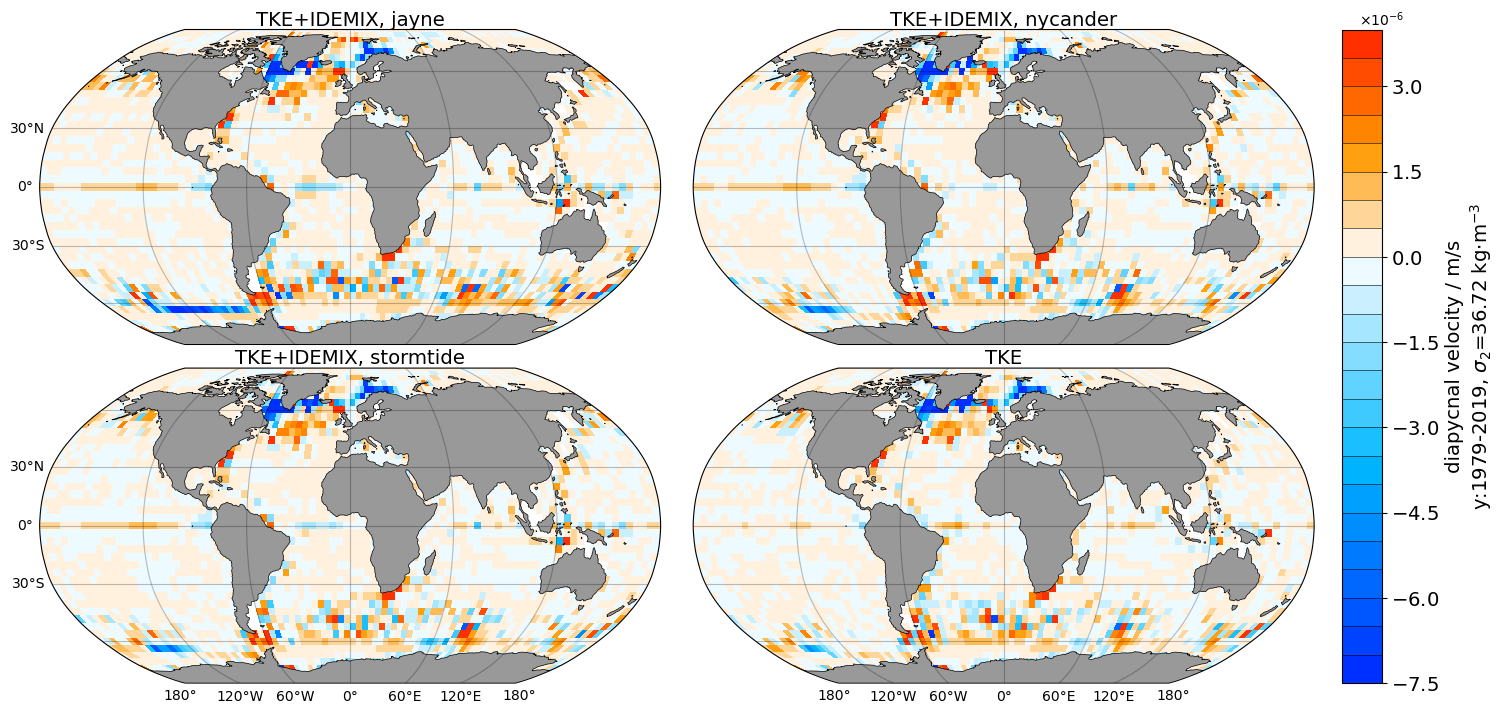

In [8]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ndat   = len(databin_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

svname = list(databin_list[0].data_vars)[0]
slabel = databin_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, databin_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  